# Energy landscape of Features (2D)

In [1]:
import pyemma 
import pyemma.coordinates as coor
import numpy as np
import h5py as h5
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyemma.util.discrete_trajectories as dt

In [5]:
pyemma.__version__

'2.5.12'

# Energy landscape of Features (1D) and Thresholds

In [6]:
from scipy.stats import *
from scipy.stats import entropy
import pyemma 
import pyemma.coordinates as coor
import numpy as np
import h5py as h5
import pickle
from scipy.signal import find_peaks
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyemma.util.discrete_trajectories as dt

In [7]:
data = h5.File('/home/ella/Desktop/fah_5_cut/data/full_features.h5', 'r')
w= np.load('/home/ella/Desktop/fah_5_cut/data/full_traj_weights.npy', allow_pickle = True)
list_dis = list(data.keys())
dt = [np.array(data[key]) for key in data.keys()]

In [8]:
def get_histogram1d(xall, nbins=100, weights=None, avoid_zero_count=False):
    z, xedge = np.histogram(xall, bins=nbins, weights=weights, density = True)
    x = 0.5 * (xedge[:-1] + xedge[1:])
    if avoid_zero_count:
        z = np.maximum(z, np.min(z[z.nonzero()]))
    return x, z.T # transpose to match x/y-directions

def _to_density(z):
    """Normalize histogram counts.
    Parameters
    ----------
    z : ndarray(T)
        Histogram counts.
    """
    return z / float(z.sum())

def _to_free_energy(z, minener_zero=False):
    """Compute free energies from histogram counts.
    Parameters
    ----------
    z : ndarray(T)
        Histogram counts.
    minener_zero : boolean, optional, default=False
        Shifts the energy minimum to zero.
    Returns
    -------
    free_energy : ndarray(T)
        The free energy values in units of kT.
    """
    pi = _to_density(z)
    free_energy = np.inf * np.ones(shape=z.shape)
    nonzero = pi.nonzero()
    free_energy[nonzero] = -np.log(pi[nonzero])
    if minener_zero:
        free_energy[nonzero] -= np.min(free_energy[nonzero])
    return free_energy

def plot_free_energy(xall,  feature, nbins = 100, weights=None, fgz = [8, 6], 
                     avoid_zero_count=False, minener_zero=False, kT =1., lw = 5, peak = False):
    x, z = get_histogram1d(xall, nbins = nbins, weights=weights, avoid_zero_count=avoid_zero_count) 
    f = _to_free_energy(z, minener_zero=minener_zero)
    cm = 1/2.54
    ft = 45
    fig, ax = plt.subplots(figsize=(fgz[0]/cm, fgz[1]/cm))
    ax.plot(x, f, linewidth = lw)
    ax.tick_params(axis='both', which='major', labelsize=ft, width = 2)
            # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'%s ($\AA$)'%feature, fontsize = ft)
    ax.set_ylabel('Free energy / kT', fontsize = ft)
    if peak == True:
        peak, _ = find_peaks(f, height=0)
        if f.max() != float('inf'):
            if x[peak[0]] < 3.:
                ax.vlines(x= x[peak[1]], ymin = f.min(), ymax = f.max(), color='black', linestyle='-.', linewidth = lw)
            else:
                ax.vlines(x= x[peak[0]], ymin = f.min(), ymax = f.max(), color='black', linestyle='-.', linewidth = lw)
        else:
            if x[peak[0]] < 3.:
                ax.vlines(x= x[peak[1]], ymin = f.min(), ymax = 16, color='black', linestyle='-.', linewidth = lw)
            else:
                ax.vlines(x= x[peak[0]], ymin = f.min(), ymax = 16, color='black', linestyle='-.', linewidth = lw)
    plt.setp(ax.spines.values(), linewidth=3)
    return x, f, peak

def get_data_for_plot(FN, nbins = 100, weights=None):
    dt = h5.File(FN, 'r')
    data = [np.array(dt[key]) for key in dt.keys()]
    keys = list(dt.keys())
    dic = {}
    for i, ft in enumerate(data):
        key = keys[i]
        dic[key] = {}
        x, z = get_histogram1d(ft, nbins = nbins, weights=weights, avoid_zero_count=False) 
        f = _to_free_energy(z, minener_zero=False)
        dic[key]['points'] = x
        dic[key]['energy'] = f
    return dic


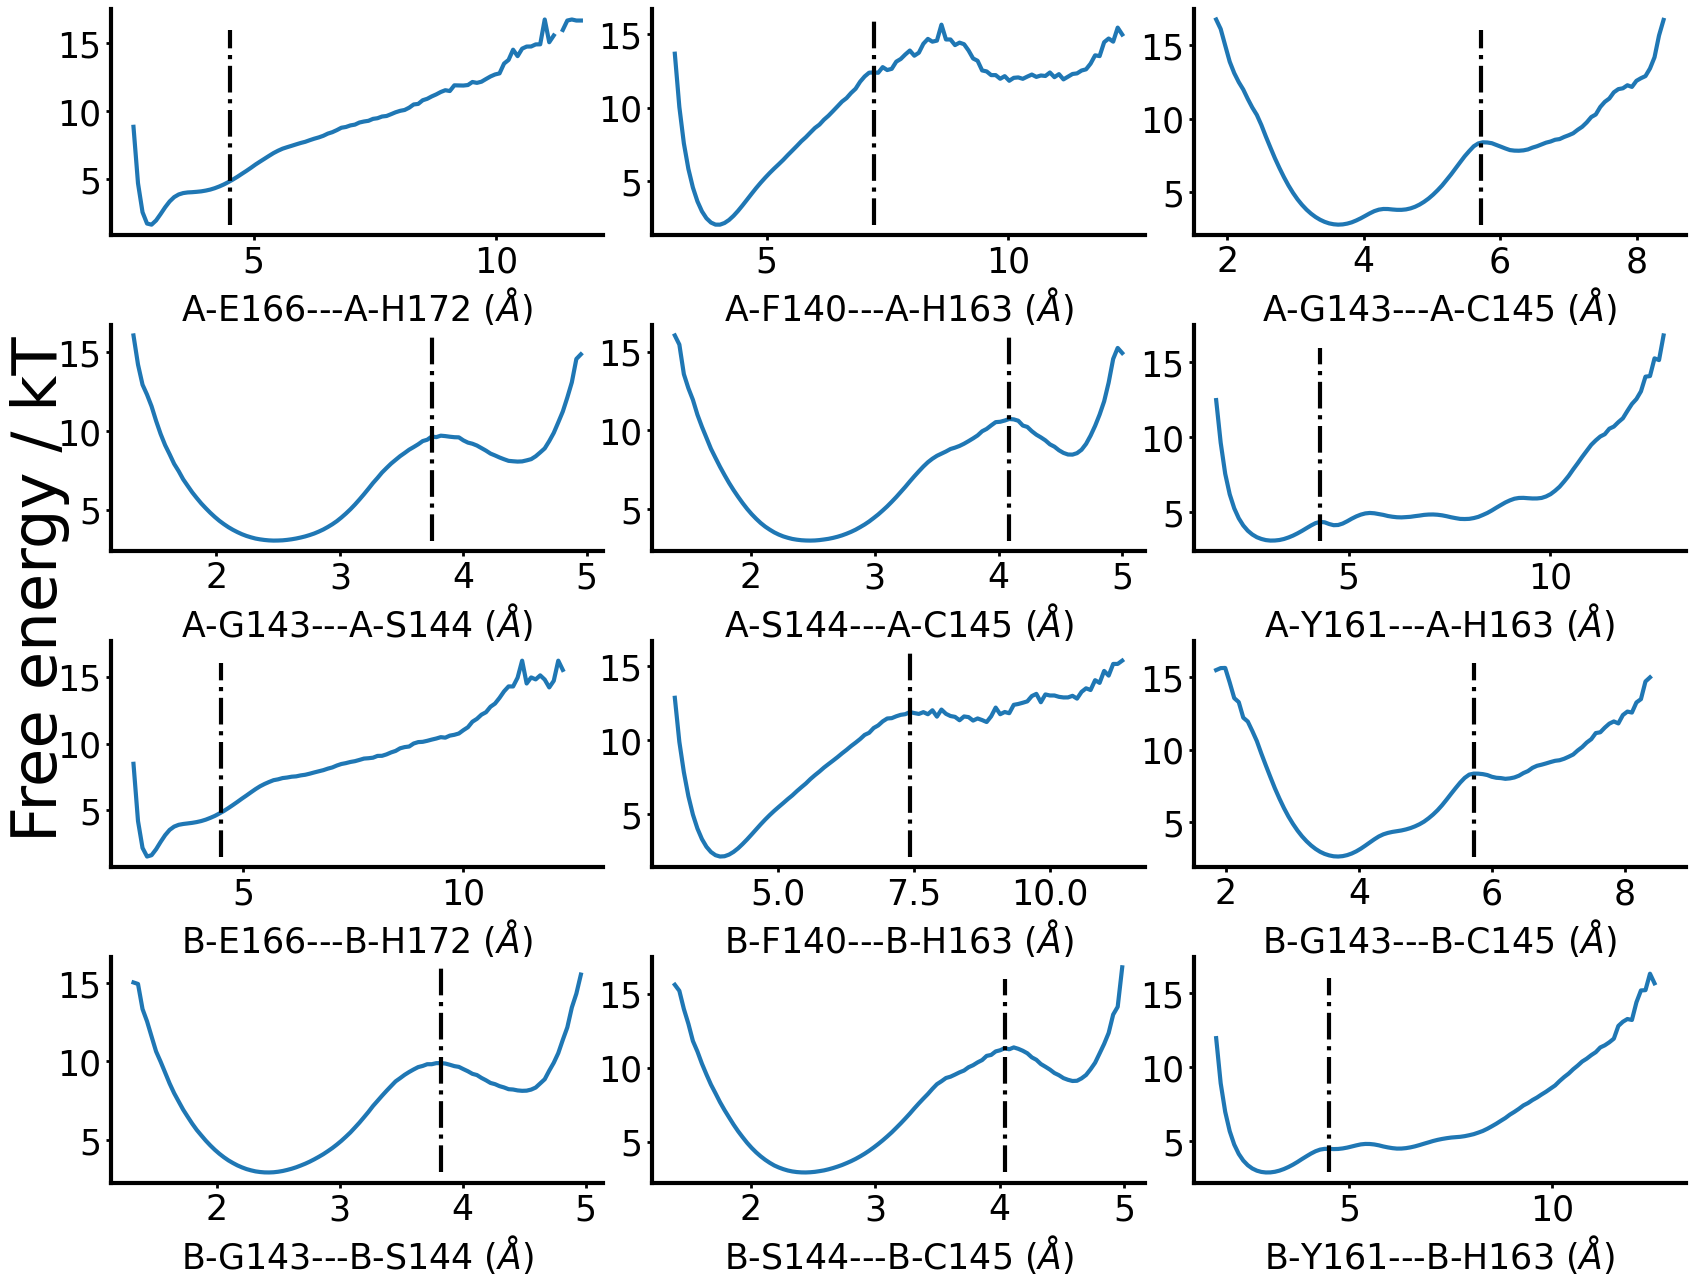

In [13]:
FN = '/home/ella/Desktop/fah_5_cut/data/full_features.h5'
w= np.load('/home/ella/Desktop/fah_5_cut/data/full_traj_weights.npy', allow_pickle = True)
test2 = get_data_for_plot(FN, weights= np.concatenate(w))
# Create a figure with 12 subplots
fgz = [8, 6]
cm = 1/2.54
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(fgz[0]/cm, fgz[1]/cm))
keys = list(test2.keys())
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.4)
# Generate data for the subplots (you can replace this with your own data)
# Plot data on each subplot
for i, ax in enumerate(axes.flat):
    ft = 25
    lw = 3
    x = test2[keys[i]]['points']
    f = test2[keys[i]]['energy']
    ax.plot(x, f, linewidth = lw)
    ax.tick_params(axis='both', which='major', labelsize=ft, width = 2)
            # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'%s ($\AA$)'%keys[i], fontsize = ft)
#     ax.set_ylabel('Free energy / kT', fontsize = ft)
    peak, _ = find_peaks(f, height=0)
    if keys[i] == 'A-E166---A-H172' or keys[i] == 'B-E166---B-H172':
        ax.vlines(x= 4.5, ymin = f.min(), ymax =16, color='black', linestyle='-.', linewidth = lw)
    elif keys[i] == 'A-G143---A-C145':
        ax.vlines(x= 5.725, ymin = f.min(), ymax = 16, color='black', linestyle='-.', linewidth = lw)
    else:
        if x[peak[0]] < 3.:
            ax.vlines(x= x[peak[1]], ymin = f.min(), ymax = 16, color='black', linestyle='-.', linewidth = lw)
        else:
            ax.vlines(x= x[peak[0]], ymin = f.min(), ymax = 16, color='black', linestyle='-.', linewidth = lw)

    plt.setp(ax.spines.values(), linewidth=3)
# Add a common y-axis title
fig.text(0.09, 0.5, 'Free energy / kT', ha='center', va='center', rotation='vertical', fontsize = 45)
plt.savefig(f'Paper_figures/features_selections/1D_energy_landscapes.png', bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

# Heat map of different features based on occupancy fingerprint

In [14]:
cluster_indexes = np.load('clustering/2nd_clustering/final_cluster_indexes.pickle', 
                        allow_pickle = True)
cluster_center_ind = np.load('clustering/2nd_clustering/list_ind_center_per_cluster.npy')

In [15]:
# Calculate the position of the target point in the whole data
def calculate_position(data, target_index):
    subset_index, point_index = target_index
    position = sum(len(subset) for subset in data[:subset_index]) + point_index
    return position

def get_data_for_plot(FN, nbins = 100, weights=None):
    dt = h5.File(FN, 'r')
    data = [np.array(dt[key]) for key in dt.keys()]
    keys = list(dt.keys())
    dic = {}
    for i, ft in enumerate(data):
        key = keys[i]
        dic[key] = {}
        x, z = get_histogram1d(ft, nbins = nbins, weights=weights, avoid_zero_count=False) 
        f = _to_free_energy(z, minener_zero=False)
        dic[key]['points'] = x
        dic[key]['energy'] = f
    return dic

In [16]:
target_indexes = []
for i, vl in enumerate(cluster_center_ind):
    target_indexes.append(cluster_indexes[i][vl])

In [17]:
positions = []
for t in target_indexes:
    positions.append(calculate_position(w, t))
positions = np.array(positions)

In [11]:
FN = '/home/ella/Desktop/fah_5_cut/data/full_features.h5'
full_dt = get_data_for_plot(FN, nbins=100, weights= np.concatenate(w))

In [12]:
thres = {}
dists = list(full_dt.keys())
for k in dists:
    ind, _ = find_peaks(full_dt[k]['energy'], height = 0)
    if k == 'A-E166---A-H172' or k == 'B-E166---B-H172':
        thres[k] = 4.5
    elif k == 'A-G143---A-C145':
        thres[k] = 5.725
    else:
        if full_dt[k]['points'][ind[0]] < 3.:
            thres[k] = full_dt[k]['points'][ind[1]]
        else:
            thres[k] = full_dt[k]['points'][ind[0]]

In [261]:
# thres = {}
# dists = list(full_dt.keys())
# for k in dists:
#     ind, _ = find_peaks(full_dt[k]['energy'], height = 0)
#     if full_dt[k]['points'][ind[0]] < 3.:
#         thres[k] = full_dt[k]['points'][ind[1]]
#     else:
#         thres[k] = full_dt[k]['points'][ind[0]]

In [13]:
thres

{'A-E166---A-H172': 4.5,
 'A-F140---A-H163': 7.215046976804733,
 'A-G143---A-C145': 5.725,
 'A-G143---A-S144': 3.7439695161581037,
 'A-S144---A-C145': 4.0861475777626035,
 'A-Y161---A-H163': 4.287753443717957,
 'B-E166---B-H172': 4.5,
 'B-F140---B-H163': 7.4294377028942105,
 'B-G143---B-C145': 5.725186383724212,
 'B-G143---B-S144': 3.8224299538135527,
 'B-S144---B-C145': 4.040404379367828,
 'B-Y161---B-H163': 4.503078755736351}

In [14]:
new_dt = {}
for i, k in enumerate(list(thres.keys())):
    x = np.array(data[k]) #[positions]
    new_dt[k] = []
    for vl in x:
        if vl <= thres[k]:
            new_dt[k].append(1)
        else:
            new_dt[k].append(0)
    new_dt[k] = np.array(new_dt[k])

In [17]:
new_dt

{'A-E166---A-H172': array([1, 1, 1, ..., 0, 1, 1]),
 'A-F140---A-H163': array([1, 1, 1, ..., 1, 1, 1]),
 'A-G143---A-C145': array([1, 1, 1, ..., 1, 1, 1]),
 'A-G143---A-S144': array([1, 1, 1, ..., 1, 1, 1]),
 'A-S144---A-C145': array([1, 1, 1, ..., 1, 1, 1]),
 'A-Y161---A-H163': array([1, 1, 1, ..., 0, 0, 0]),
 'B-E166---B-H172': array([1, 1, 1, ..., 1, 1, 1]),
 'B-F140---B-H163': array([1, 1, 1, ..., 1, 1, 1]),
 'B-G143---B-C145': array([1, 1, 1, ..., 1, 1, 1]),
 'B-G143---B-S144': array([1, 1, 1, ..., 1, 1, 1]),
 'B-S144---B-C145': array([1, 1, 1, ..., 1, 1, 1]),
 'B-Y161---B-H163': array([1, 1, 1, ..., 0, 0, 0])}

In [54]:
import matplotlib as mpl
def plot_mx(MX, lis_feat):
    PC_name = lis_feat
    fgz = [8, 6]
    cm = 1/2.54
    ft = 25
    fig, ax = plt.subplots(figsize=(fgz[0]/cm, fgz[1]/cm))
    im = ax.imshow(MX, cmap = 'YlOrBr')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(PC_name)))
    ax.set_yticks(np.arange(len(PC_name)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(PC_name, fontsize = ft)
    ax.set_yticklabels(PC_name, fontsize = ft)
    ax.tick_params(axis='both', which='major', labelsize=ft, width = 2)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(PC_name)):
        for j in range(len(PC_name)):
            text = ax.text(j, i, MX[i, j],
                           ha="center", va="center", color="black", fontsize = ft)

#     ax.set_title("Tanimoto similarity between features", fontsize = ft)
    fig.tight_layout()
    cb = fig.colorbar(im, ax = ax, shrink=1)
    cb.ax.tick_params(labelsize=ft)
    plt.savefig(f'Paper_figures/features_selections/Tanimoto_matrix_pairwise_of_features.png', bbox_inches ="tight",
            pad_inches = 0.5,
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

In [39]:
from scipy.spatial import distance
def mx_tanimoto(x, probs):
    mx = []
    for n in range (len(x)):
        dis = []
        for m in range (len(x)):
            dis.append(np.around(1- distance.rogerstanimoto(x[n], x[m], w= probs), decimals= 2))
        dis = np.array(dis)
        mx.append(dis)
    return mx

In [40]:
probs = np.load('/home/ella/Desktop/fah_5_cut/MSM/pyemma/populations_40.npy')
occupancy = [np.array(new_dt[key]) for key in list(new_dt.keys())]
tanimoto = np.matrix(mx_tanimoto(occupancy, probs= np.concatenate(w)))

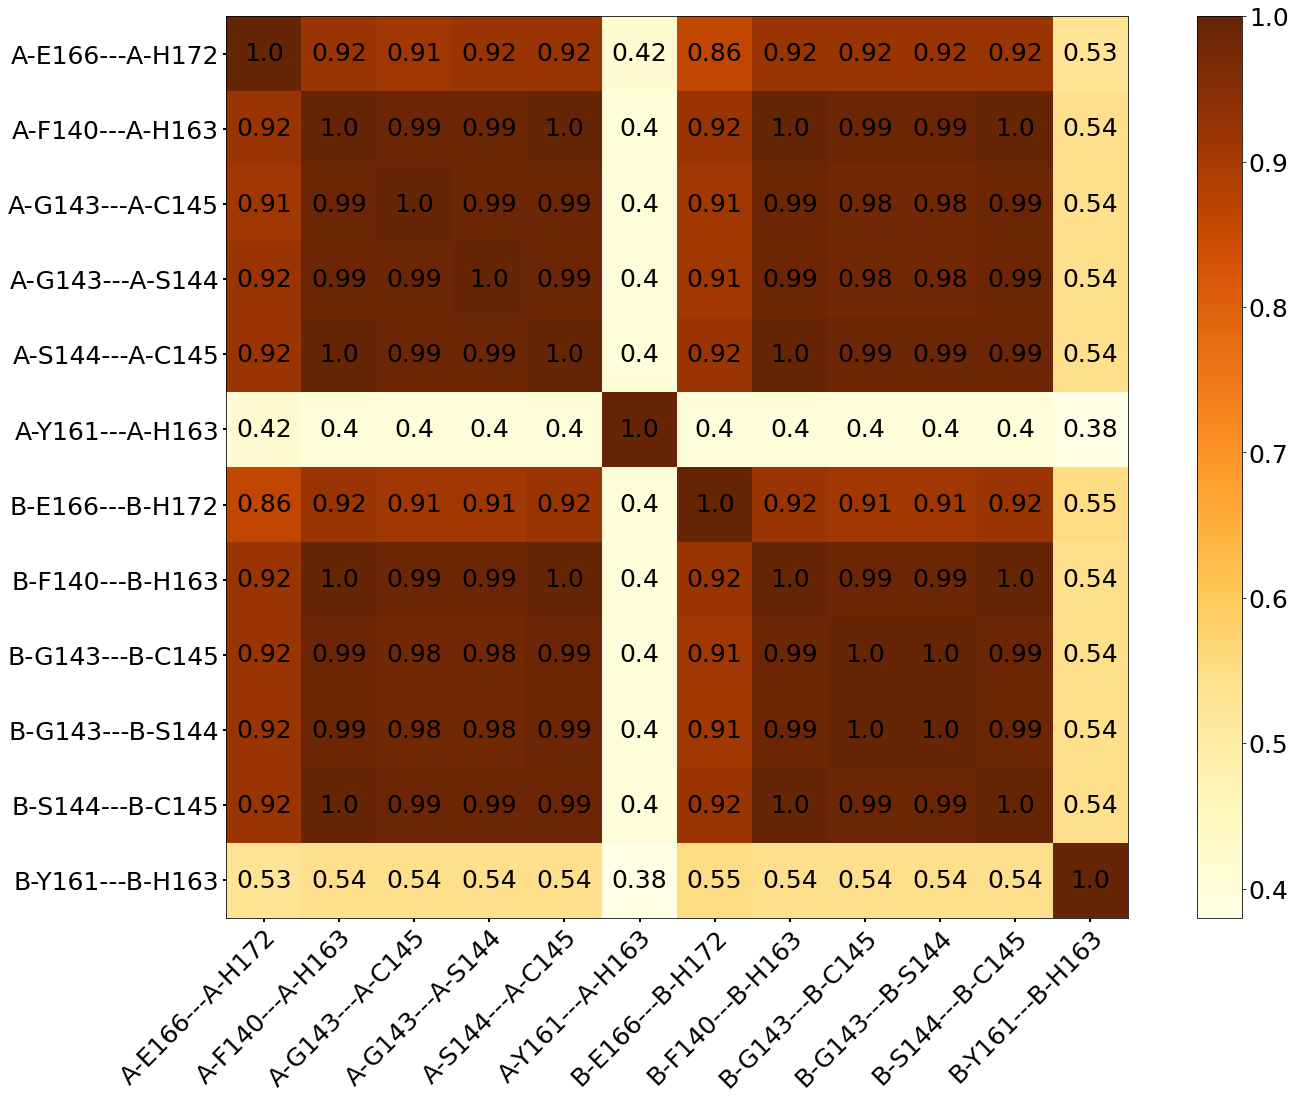

In [55]:
plot_mx(tanimoto, lis_feat= list(new_dt.keys()))

In [17]:
import scipy
scipy.__version__

'1.5.3'